In [1]:
from flax import linen as nn 
from flax.linen import initializers
from flax.core import freeze, unfreeze
from flax.linen.module import compact
from basic import logprior_fn, logvariational_fn, samplevariational_fn, sigmas_from_rhos, ScaleMixturePrior
from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as random
from jax import lax
PRNGKey = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?
Array = Any
default_kernel_init = initializers.lecun_normal()
from jax.random import PRNGKey, split
import optax

In [21]:
class BNNLayer(nn.Module):

    features: int
    logprior_fn: Callable
    parameter_init: Callable = nn.initializers.lecun_normal()

    @compact
    def __call__(self, key: random.PRNGKey, inputs):
        # Variational Parameters
        mus = self.param(
            "mus", 
            self.parameter_init, 
            (jnp.shape(inputs)[-1] + 1, self.features)) # +1 for bias
        rhos = self.param(
            "rhos",
            self.parameter_init,
            (jnp.shape(inputs)[-1] + 1, self.features) # +1 for bias
        )

        # Sample weights
        weights_and_biases = samplevariational_fn(
            mus=mus,
            rhos=rhos,
            key=key,
        )


        weights = weights_and_biases[:-1]
        biases = weights_and_biases[-1]


        y = jnp.dot(inputs, weights) + biases


        log_variational_density = logvariational_fn(
            weights=weights,
            mus=mus,
            rhos=rhos,
        )
        log_prior_density = self.logprior_fn(weights)
        
        return y, log_variational_density, log_prior_density



In [22]:
prior_fn = ScaleMixturePrior(pi=0.5, var1=0.99, var2=0.01)
model = BNNLayer(1, prior_fn)

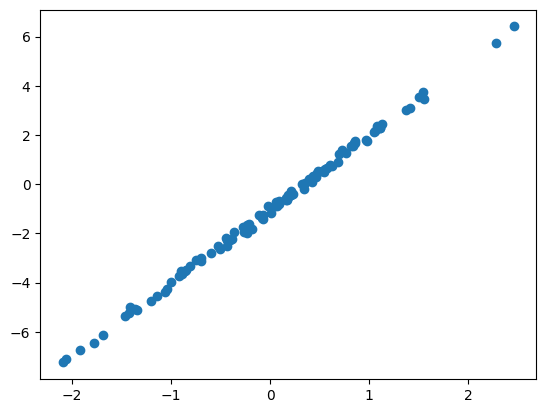

In [23]:
import numpy as np

xs = np.random.normal(size=(100,1))
noise = np.random.normal(scale=0.1, size=(100,1))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [24]:
key = PRNGKey(123)

key, subkey = split(key)
key, sampling_key = split(key)
# model = BNNLayer(1, 0.5, 0.99, 0.001)
params = model.init(subkey, sampling_key, xs[0])


def elbo(params, model, x, y, key, kl_weight):
    # // Gather outputs from model
    key, subkey = split(key)
    logits, log_var_density, log_prior_density = model.apply(params, subkey, x)

    # // Calculate negative log likelihood
    mse = jnp.mean((logits - y) ** 2)
    
    # // Calculate kl penalty
    kl_penalty = kl_weight * (log_var_density - log_prior_density)
    
    elbo = mse + kl_penalty
    return elbo, (mse, kl_penalty) # for logging




def train_loop(opt, opt_state, model, params, xs, ys, key, kl_weight):

    key, subkey = split(key)

    # // Calculate elbo and gradient as well as auxiliary info
    (elbo_val, (mse, kl_penalty)), grad = jax.value_and_grad(elbo, has_aux=True)(params, model, xs, ys, subkey, kl_weight)
    print(f"MSE: {mse} | KL penalty: {kl_penalty}")

    # // Update parameters
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params


epochs = 400
kl_weight = 0.01
opt = optax.sgd(learning_rate=0.002)
opt_state = opt.init(params)
for i in range(epochs):
    params = train_loop(opt, opt_state, model, params, xs, ys, key, kl_weight)


    


MSE: 9.859128952026367 | KL penalty: 0.01581258326768875
MSE: 9.792753219604492 | KL penalty: 0.01585368812084198
MSE: 9.726788520812988 | KL penalty: 0.01585482247173786
MSE: 9.661230087280273 | KL penalty: 0.01580626145005226
MSE: 9.596057891845703 | KL penalty: 0.0156963299959898
MSE: 9.531259536743164 | KL penalty: 0.015511653386056423
MSE: 9.466818809509277 | KL penalty: 0.015237751416862011
MSE: 9.402718544006348 | KL penalty: 0.014860132709145546
MSE: 9.338942527770996 | KL penalty: 0.014365767128765583
MSE: 9.275477409362793 | KL penalty: 0.013744865544140339
MSE: 9.212313652038574 | KL penalty: 0.012992586940526962
MSE: 9.14945125579834 | KL penalty: 0.012110336683690548
MSE: 9.08689022064209 | KL penalty: 0.011106245219707489
MSE: 9.024641036987305 | KL penalty: 0.00999466609209776
MSE: 8.96271800994873 | KL penalty: 0.00879485160112381
MSE: 8.901141166687012 | KL penalty: 0.007529075723141432
MSE: 8.83992862701416 | KL penalty: 0.006220712326467037
MSE: 8.779098510742188 | K

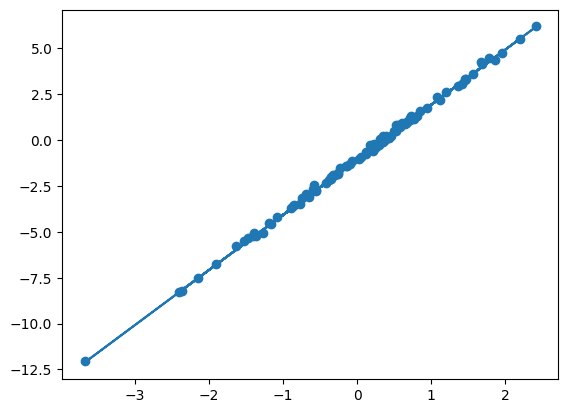

In [16]:
plt.scatter(xs, ys)
plt.plot(xs, model.apply(params, subkey, xs)[0])